In [3]:
import numpy as np
import pandas as pd
import plotly.express as px
import molplotly
import torch
import umap
import seaborn as sns
import dreams.utils.data as du
import dreams.utils.mols as mu
from rdkit import Chem
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from dreams.definitions import NIST20, PRETRAINED, MONA
from dreams.utils.dformats import DataFormatA
from dreams.models.dreams.dreams import DreaMS, get_embeddings
from dreams.utils.mols import formula_to_dict
from dreams.utils.plots import init_plotting, save_fig
from dreams.utils.dreams import get_dreams_embeddings
init_plotting()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# df = pd.read_pickle(MONA / 'mona_clean_A.pkl').reset_index(drop=True)


In [10]:
from math import log, sqrt, pow

df = pd.read_pickle(MONA / 'mona_clean_A_10k_np_classes.pkl').reset_index(drop=True)

df['formula'] = df['FORMULA'].apply(mu.formula_to_dict)
df['Num. rings'] = df['ROMol'].apply(lambda m: len(Chem.GetSSSR(m)))
df['Has halogens'] = df['SMILES'].apply(lambda s: 'cl' in s.lower() or 'f' in s.lower() or 'br' in s.lower() or 'i' in s.lower()).astype(int)
df['Has N and S'] = df['SMILES'].apply(lambda s: 's' in s.lower() and 'n' in s.lower()).astype(int)
df['Is carbohydrate'] = df['formula'].apply(lambda f: f.keys() == {'C', 'H', 'O'}).astype(int)
df['#Br'] = df['formula'].apply(lambda f: f['Br'])
df['#P'] = df['formula'].apply(lambda f: f['P'])
df['#S'] = df['formula'].apply(lambda f: f['S'])
df['#O'] = df['formula'].apply(lambda f: f['O'])
df['#N'] = df['formula'].apply(lambda f: f['N'])
df['#F'] = df['formula'].apply(lambda f: f['F'])
df['#C'] = df['formula'].apply(lambda f: f['C'])
# df['log(#O/#C)'] = df['FORMULA'].apply(lambda f: pow(f['O'] / f['C'], 1/4) if f['O'] else 0)
df['QED'] = df['ROMol'].apply(Chem.QED.qed)
df['ALOGP'] = df['ROMol'].apply(lambda m: Chem.QED.properties(m)[1])

df['EXACT MASS'] = df['EXACT MASS'].astype(float)
# df['diameter node'] = df['index'].apply(lambda i: i in diameter_nodes).astype(int)

In [11]:
model_pth = PRETRAINED / 'CtDh6OHlhA_epoch=0-step=2500.ckpt'
embs = get_dreams_embeddings(model_pth, df, batch_size=32, tqdm_batches=True, n_highest_peaks=60)

Computing DreaMS: 100%|██████████| 313/313 [02:18<00:00,  2.26it/s]


In [49]:
reducer = umap.UMAP(metric='cosine', n_components=3)#, min_dist=0.4)
umap_embs = reducer.fit_transform(embs.detach().numpy())
umap_embs.shape

(10000, 3)

In [44]:
embs.shape

torch.Size([10000, 1024])

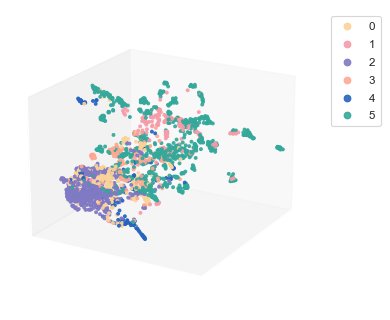

In [105]:
from dreams.utils.plots import get_nature_hex_colors
import re, seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

colors = get_nature_hex_colors() + ['#FEA992']
colors = [colors[3], colors[2], colors[4], colors[5], colors[0], colors[1]]

col = 'superclass_results'
classes = [c for c in df[col].value_counts().index.tolist()[1:15] if ('alkaloid' not in c and 'Sesq' not in c)]
df_ = df.reset_index().copy()

idx = df_[df_[col].isin(classes)].index.tolist()

# reducer = umap.UMAP(metric='cosine', n_components=3, min_dist=0.4, n_neighbors=15)
# umap_embs = reducer.fit_transform(embs.numpy()[idx])
#
# x = umap_embs[:, 0]
# y = umap_embs[:, 1]
# z = umap_embs[:, 2]

c = df.iloc[idx]['superclass_results'].astype('category').cat.rename_categories(range(df.iloc[idx]['superclass_results'].nunique())).astype(int)

# axes instance
fig = plt.figure(figsize=(3, 3))
ax = Axes3D(fig)
fig.add_axes(ax)

# get colormap from seaborn
# cmap = ListedColormap(sns.color_palette("Set2", 7).as_hex())

cmap = ListedColormap(colors)

# import dreams.utils.plots as plots
# cmap = plots.get_palette()

# plot
sc = ax.scatter(x, y, z, s=4, c=c, marker='o', cmap=cmap, depthshade=False, alpha=0.9)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.view_init(elev=20, azim=30)

ax.grid(False)

ax.set_xlim(-2, 15)
ax.set_ylim(-3, 6)
ax.set_zlim(-3, 7.2)
ax.xaxis.line.set_color('w')
ax.yaxis.line.set_color('w')
ax.zaxis.line.set_color('w')

# legend
ax.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
save_fig('dreams_3d.svg')
plt.savefig("scatter_hue", bbox_inches='tight')

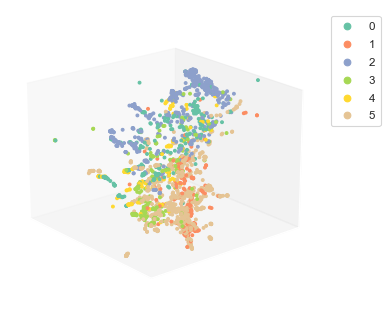

In [548]:
import re, seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

col = 'superclass_results'
classes = [c for c in df[col].value_counts().index.tolist()[1:15] if ('alkaloid' not in c and 'Sesq' not in c)]
df_ = df.reset_index().copy()
idx = df_[df_[col].isin(classes)].index.tolist()

x = umap_embs[idx, 0]
y = umap_embs[idx, 1]
z = umap_embs[idx, 2]
c = df.iloc[idx]['superclass_results'].astype('category').cat.rename_categories(range(df.iloc[idx]['superclass_results'].nunique())).astype(int)

# axes instance
fig = plt.figure(figsize=(3, 3))
ax = Axes3D(fig)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("Set2", 7).as_hex())

# import dreams.utils.plots as plots
# cmap = plots.get_palette()

# plot
sc = ax.scatter(x, y, z, s=4, c=c, marker='o', cmap=cmap, depthshade=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.view_init(elev=20, azim=-40)

ax.grid(False)

ax.set_xlim(0.5, 9)
ax.set_ylim(-1.5, 6)
ax.set_zlim(-3, 5)
ax.xaxis.line.set_color('w')
ax.yaxis.line.set_color('w')
ax.zaxis.line.set_color('w')

# legend
ax.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
save_fig('dreams_3d.svg')
plt.savefig("scatter_hue", bbox_inches='tight')

In [541]:
pd.DataFrame({'cats': df.iloc[idx]['superclass_results'].astype('category').cat.rename_categories(range(df.iloc[idx]['superclass_results'].nunique())).astype(int), 'original': df.iloc[idx]['superclass_results']}).drop_duplicates().sort_values('cats')

cats                    original
22926     0                   Coumarins
7505      1  Fatty Acids and Conjugates
3541      2                  Flavonoids
11022     3      Phenolic acids (C6-C1)
8058      4    Phenylpropanoids (C6-C3)
6626      5              Small peptides

In [299]:
classes

['Small peptides',
 'Flavonoids',
 'Coumarins',
 'Phenolic acids (C6-C1)',
 'Fatty Acids and Conjugates',
 'Sesquiterpenoids',
 'Phenylpropanoids (C6-C3)']

In [55]:
def round_formula(f, k=5):
    return {key: round(value / k) * k + 1 for key, value in f.items()}

df['FORMULA round'] = df['FORMULA'].apply(mu.formula_to_dict).apply(round_formula).apply(str)
df['FORMULA round'].nunique()

55

In [60]:
df['FORMULA keys'] = df['FORMULA'].apply(mu.formula_to_dict).apply(lambda f: str(list(f.keys())))
df['FORMULA keys'].nunique()

47

In [69]:
df['FORMULA keys merged halogens'] = df['FORMULA'].apply(mu.formula_to_dict).apply(lambda f: str(list(set([(k if k not in ['Br', 'Cl', 'F', 'I'] else 'Br/Cl/F/I') for k in f.keys()]))))
df['FORMULA keys merged halogens'].nunique()

28

In [257]:
label_col = 'superclass_results'

if df[label_col].dtype == 'object':
    labels_ = df[label_col].astype('category').cat.rename_categories(range(df[label_col].nunique())).astype(int)
else:
    labels_ = df[label_col]

# generate a scatter plot
fig = px.scatter(x=umap_embs[:, 0], y=umap_embs[:, 1], color=labels_, width=700, height=600)#, color_discrete_sequence=px.colors.qualitative.Antique)`

if not 'i' in df.columns:
    df['i'] = df.index.tolist()

# add molecules to the plotly graph - returns a Dash app
app = molplotly.add_molecules(fig=fig,
                              df=df,
                              smiles_col='SMILES',
                              title_col='i',
                              )

# run Dash app inline in notebook (or in an external server)
app.run_server(mode='inline', port=8700, height=600)

Dash is running on http://127.0.0.1:8700/



In [6]:
# np_classes = mu.np_classify(df['SMILES'])
#
# for k in np_classes[0].keys():
#     if 'results' in k:
#         df[k] = [c[k][0] if c[k] else '' for c in np_classes]
#
# df.to_pickle(MONA / 'mona_clean_A_10k_np_classes.pkl')

100%|██████████| 10000/10000 [2:05:26<00:00,  1.33it/s] 


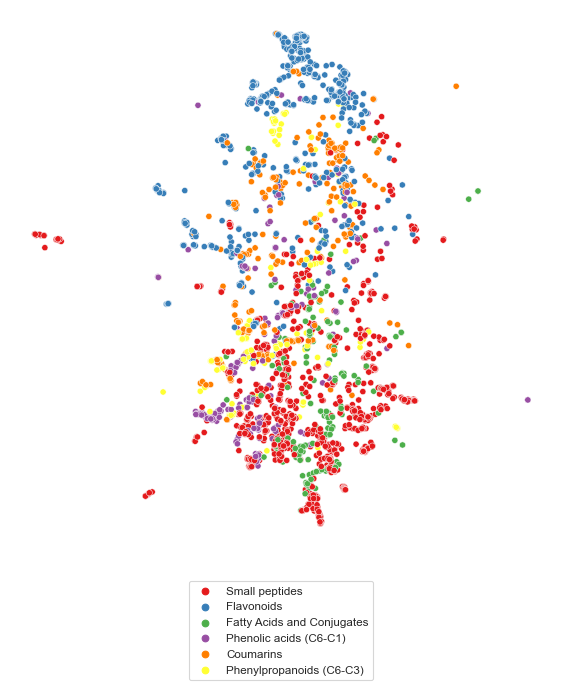

Dash is running on http://127.0.0.1:8700/



In [416]:
from dreams.utils.io import savefig
from dreams.definitions import FIGURES

init_plotting(figsize=(7, 7), style='white')

col = 'superclass_results'
# classes = [c for c in df[col].value_counts().index.tolist()[1:15] if 'alkaloid' not in c]#['Small peptides', 'Steroids', 'Monoterpenoids', 'Sesquiterpenoids', 'Diterpenoids']
df_ = df.reset_index().copy()
idx = df_[df_[col].isin(classes)].index.tolist()

# idx = df[df['superclass_results'].apply(lambda c: 'terpen' in c.lower())].index

sns.scatterplot(x=umap_embs[idx, 1], y=umap_embs[idx, 2], s=20, hue=df_[col].iloc[idx], palette='Set1')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
plt.axis('off')

plt.show()

# savefig('np_classes_umap', FIGURES, extension='.pdf')

fig = px.scatter(x=umap_embs[idx, 1], y=umap_embs[idx, 2], color=df.iloc[idx]['PRECURSOR M/Z'], width=700, height=600)
app = molplotly.add_molecules(fig=fig,
                              df=df.iloc[idx],
                              smiles_col='SMILES',
                              title_col='NAME',
                              )


app.run_server(mode='inline', port=8700, height=600)

In [546]:
df[df['NAME'].apply(lambda s: s.startswith('4-Hydroxycoumarin'))]

NAME                           SYNONYMS PRECURSOR TYPE  \
5963  4-Hydroxycoumarin             4-hydroxychromen-2-one         [M+H]+   
5949  4-Hydroxycoumarin             4-hydroxychromen-2-one         [M+H]+   
5953  4-Hydroxycoumarin             4-hydroxychromen-2-one         [M+H]+   
5958  4-Hydroxycoumarin             4-hydroxychromen-2-one         [M+H]+   
4719  4-Hydroxycoumarin  CID 14101\n2-hydroxychromen-4-one         [M+H]+   
4485  4-Hydroxycoumarin  CID 14101\n2-hydroxychromen-4-one         [M+H]+   
4484  4-Hydroxycoumarin  CID 14101\n2-hydroxychromen-4-one         [M+H]+   
5968  4-Hydroxycoumarin             4-hydroxychromen-2-one         [M+H]+   

     SPECTRUM TYPE  PRECURSOR M/Z INSTRUMENT TYPE  \
5963           MS2        163.039     LC-ESI-ITFT   
5949           MS2        163.039     LC-ESI-ITFT   
5953           MS2        163.039     LC-ESI-ITFT   
5958           MS2        163.039     LC-ESI-ITFT   
4719           MS2        163.039     LC-ESI-ITFT   
4485           MS2        163.039     LC-ESI-ITFT   
4484           MS2        163.039     LC-ESI-ITFT   
5968           MS2        163.039     LC-ESI-ITFT   

                             INSTRUMENT COLLISION ENERGY ION MODE  \
5963  LTQ Orbitrap XL Thermo Scientific  100 % (nominal)        P   
5949  LTQ Orbitrap XL Thermo Scientific  180 % (nominal)        P   
5953  LTQ Orbitrap XL Thermo Scientific  160 % (nominal)        P   
5958  LTQ Orbitrap XL Thermo Scientific  130 % (nominal)        P   
4719  LTQ Orbitrap XL Thermo Scientific    75% (nominal)        P   
4485  LTQ Orbitrap XL Thermo Scientific    95% (nominal)        P   
4484  LTQ Orbitrap XL Thermo Scientific   100% (nominal)        P   
5968  LTQ Orbitrap XL Thermo Scientific   70 % (nominal)        P   

                         INCHIKEY  ... #S  #O #N #F #C       QED   ALOGP  \
5963  VXIXUWQIVKSKSA-UHFFFAOYSA-N  ...  0   3  0  0  9  0.596945  1.4986   
5949  VXIXUWQIVKSKSA-UHFFFAOYSA-N  ...  0   3  0  0  9  0.596945  1.4986   
5953  VXIXUWQIVKSKSA-UHFFFAOYSA-N  ...  0   3  0  0  9  0.596945  1.4986   
5958  VXIXUWQIVKSKSA-UHFFFAOYSA-N  ...  0   3  0  0  9  0.596945  1.4986   
4719  OWBBAPRUYLEWRR-UHFFFAOYSA-N  ...  0   3  0  0  9  0.638129  1.4986   
4485  OWBBAPRUYLEWRR-UHFFFAOYSA-N  ...  0   3  0  0  9  0.638129  1.4986   
4484  OWBBAPRUYLEWRR-UHFFFAOYSA-N  ...  0   3  0  0  9  0.638129  1.4986   
5968  VXIXUWQIVKSKSA-UHFFFAOYSA-N  ...  0   3  0  0  9  0.596945  1.4986   

                 FORMULA round     FORMULA keys FORMULA keys merged halogens  
5963  {'C': 1, 'H': 1, 'O': 1}  ['C', 'H', 'O']              ['O', 'C', 'H']  
5949  {'C': 1, 'H': 1, 'O': 1}  ['C', 'H', 'O']              ['O', 'C', 'H']  
5953  {'C': 1, 'H': 1, 'O': 1}  ['C', 'H', 'O']              ['O', 'C', 'H']  
5958  {'C': 1, 'H': 1, 'O': 1}  ['C', 'H', 'O']              ['O', 'C', 'H']  
4719  {'C': 1, 'H': 1, 'O': 1}  ['C', 'H', 'O']              ['O', 'C', 'H']  
4485  {'C': 1, 'H': 1, 'O': 1}  ['C', 'H', 'O']              ['O', 'C', 'H']  
4484  {'C': 1, 'H': 1, 'O': 1}  ['C', 'H', 'O']              ['O', 'C', 'H']  
5968  {'C': 1, 'H': 1, 'O': 1}  ['C', 'H', 'O']              ['O', 'C', 'H']  

[8 rows x 44 columns]

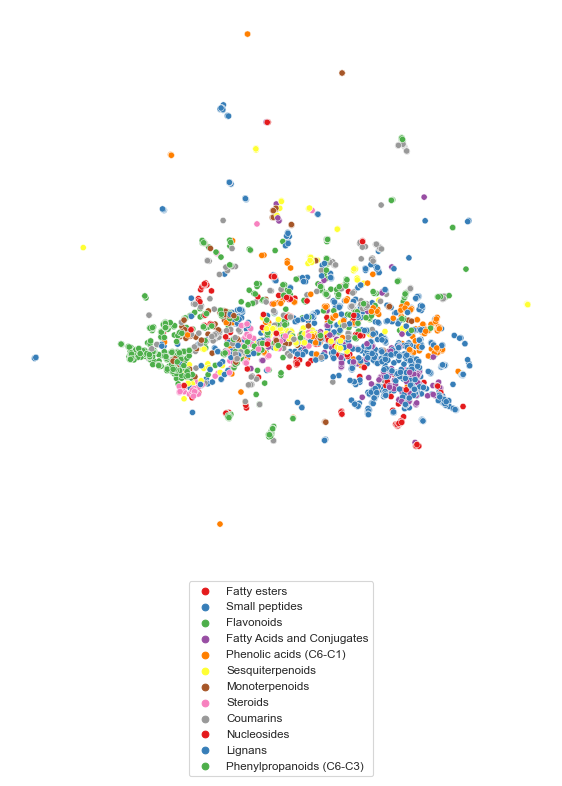

In [82]:
from dreams.utils.io import savefig
from dreams.definitions import FIGURES

init_plotting(figsize=(7, 7), style='white')

col = 'superclass_results'
classes = [c for c in df[col].value_counts().index.tolist()[1:20] if 'alkaloid' not in c]#['Small peptides', 'Steroids', 'Monoterpenoids', 'Sesquiterpenoids', 'Diterpenoids']
df_ = df.reset_index().copy()
idx = df_[df_[col].isin(classes)].index.tolist()

# idx = df[df['superclass_results'].apply(lambda c: 'terpen' in c.lower())].index

sns.scatterplot(x=umap_embs[idx, 0], y=umap_embs[idx, 1], s=20, hue=df_[col].iloc[idx], palette='Set1')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
plt.axis('off')
savefig('np_classes_umap', FIGURES, extension='.pdf')

In [24]:
df

NAME  \
22104                            N-Bisdesmethyl Tramadol   
5038                                         Hyoscyamine   
12688                                    g-Butyrobetaine   
11128                                           Atrazine   
2855                                      Saikosaponin D   
...                                                  ...   
10522                                         Isoprocarb   
17783                                  Atrazine-desethyl   
13241                                         Etofylline   
19992  NCGC00384927-01!8-[4,5-dihydroxy-6-(hydroxymet...   
11455                                          Glipizide   

                                                SYNONYMS PRECURSOR TYPE  \
22104  BRN 2851491\n2-(aminomethyl)-1-(3-methoxypheny...         [M+H]+   
5038                                                             [M+H]+   
12688   4-Trimethylammoniobutanoate\ngamma-Butyrobetaine         [M+H]+   
11128  6-chloro-4-N-ethyl-2-N-propan-2-yl-1,3,5-triaz...         [M+H]+   
2855                                                             [M+H]+   
...                                                  ...            ...   
10522            (2-propan-2-ylphenyl) N-methylcarbamate         [M+H]+   
17783  Deethylatrazine\n(4-amino-6-chloro-s-triazin-2...         [M+H]+   
13241  7-(2-Hydroxyethyl)-1,3-dimethyl-3,7-dihydro-1H...         [M+H]+   
19992                                                           [M+Na]+   
11455  N-[2-[4-(cyclohexylcarbamoylsulfamoyl)phenyl]e...         [M+H]+   

      SPECTRUM TYPE  PRECURSOR M/Z INSTRUMENT TYPE  \
22104           MS2     236.164500     LC-ESI-QTOF   
5038            MS2     290.175100     LC-ESI-ITFT   
12688           MS2     146.000000       LC-ESI-QQ   
11128           MS2     216.101000      LC-ESI-QFT   
2855            MS2     781.473269     LC-ESI-QTOF   
...             ...            ...             ...   
10522           MS2     194.117600      LC-ESI-QFT   
17783           MS2     188.069700     LC-ESI-ITFT   
13241           MS2     225.098300      LC-ESI-QFT   
19992           MS2     615.168000             nan   
11455           MS2     446.185700      LC-ESI-QFT   

                                    INSTRUMENT COLLISION ENERGY ION MODE  \
22104                      Bruker maXis Impact            30 eV        P   
5038         LTQ Orbitrap XL Thermo Scientific    55% (nominal)        P   
12688              API3000, Applied Biosystems             50 V        P   
11128  Q Exactive Orbitrap (Thermo Scientific)               90        P   
2855                      Waters Xevo G2 Q-Tof            10 eV        P   
...                                        ...              ...      ...   
10522  Q Exactive Orbitrap (Thermo Scientific)               75        P   
17783        LTQ Orbitrap XL Thermo Scientific   60 % (nominal)        P   
13241      Q Exactive Thermo Fisher Scientific    65% (nominal)        P   
19992                 Maxis II HD Q-TOF Bruker              NaN        P   
11455  Q Exactive Orbitrap (Thermo Scientific)               15        P   

                          INCHIKEY  ...  \
22104  QNPPIKMBCJUUTG-UHFFFAOYSA-N  ...   
5038   RKUNBYITZUJHSG-FXUDXRNXSA-N  ...   
12688  JHPNVNIEXXLNTR-UHFFFAOYSA-N  ...   
11128  MXWJVTOOROXGIU-UHFFFAOYSA-N  ...   
2855   KYWSCMDFVARMPN-DISCDMJRSA-N  ...   
...                            ...  ...   
10522  QBSJMKIUCUGGNG-UHFFFAOYSA-N  ...   
17783  DFWFIQKMSFGDCQ-UHFFFAOYSA-N  ...   
13241  NWPRCRWQMGIBOT-UHFFFAOYSA-N  ...   
19992                          NaN  ...   
11455  ZJJXGWJIGJFDTL-UHFFFAOYSA-N  ...   

                                     MASS SPECTRAL PEAKS  \
22104  121.064 100.000000\n122.0677 11.094538\n123.06...   
5038   67.0542 1.228421\n70.065 0.466624\n77.0385 0.9...   
12688  38.900 1.476015\n41.000 11.439114\n43.000 49.3...   
11128  53.0022 0.741534\n61.9792 13.654121\n68.0243 1...   
2855   419.33481 3.600000\n426.67554 4.300000\n437.

In [23]:
df['superclass_results'].nunique()

63

In [35]:
df[col].iloc[idx]

22104                              
5038            Ornithine alkaloids
12688                  Fatty esters
11128               Pseudoalkaloids
2855                  Triterpenoids
                    ...            
3800             Tyrosine alkaloids
18532                              
6659           Tryptophan alkaloids
8584     Fatty Acids and Conjugates
19269                       Lignans
Name: superclass_results, Length: 2887, dtype: object

In [36]:
df[df[col].isin(classes)][col]

5038     Ornithine alkaloids
11128        Pseudoalkaloids
6626          Small peptides
8179          Small peptides
3541              Flavonoids
                ...         
7574         Pseudoalkaloids
7929          Small peptides
17783        Pseudoalkaloids
13241        Pseudoalkaloids
19992             Flavonoids
Name: superclass_results, Length: 2887, dtype: object

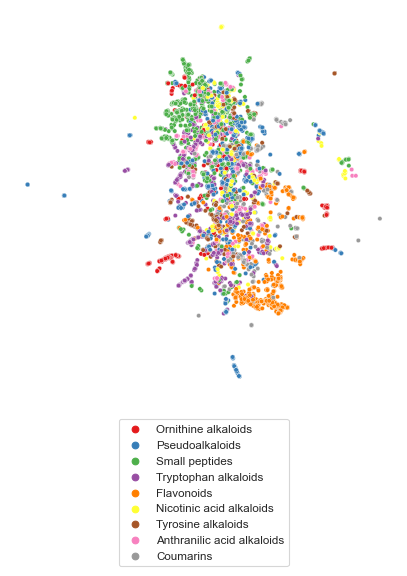

In [89]:
df

NAME  \
22104                            N-Bisdesmethyl Tramadol   
5038                                         Hyoscyamine   
12688                                    g-Butyrobetaine   
11128                                           Atrazine   
2855                                      Saikosaponin D   
...                                                  ...   
10522                                         Isoprocarb   
17783                                  Atrazine-desethyl   
13241                                         Etofylline   
19992  NCGC00384927-01!8-[4,5-dihydroxy-6-(hydroxymet...   
11455                                          Glipizide   

                                                SYNONYMS PRECURSOR TYPE  \
22104  BRN 2851491\n2-(aminomethyl)-1-(3-methoxypheny...         [M+H]+   
5038                                                             [M+H]+   
12688   4-Trimethylammoniobutanoate\ngamma-Butyrobetaine         [M+H]+   
11128  6-chloro-4-N-ethyl-2-N-propan-2-yl-1,3,5-triaz...         [M+H]+   
2855                                                             [M+H]+   
...                                                  ...            ...   
10522            (2-propan-2-ylphenyl) N-methylcarbamate         [M+H]+   
17783  Deethylatrazine\n(4-amino-6-chloro-s-triazin-2...         [M+H]+   
13241  7-(2-Hydroxyethyl)-1,3-dimethyl-3,7-dihydro-1H...         [M+H]+   
19992                                                           [M+Na]+   
11455  N-[2-[4-(cyclohexylcarbamoylsulfamoyl)phenyl]e...         [M+H]+   

      SPECTRUM TYPE  PRECURSOR M/Z INSTRUMENT TYPE  \
22104           MS2     236.164500     LC-ESI-QTOF   
5038            MS2     290.175100     LC-ESI-ITFT   
12688           MS2     146.000000       LC-ESI-QQ   
11128           MS2     216.101000      LC-ESI-QFT   
2855            MS2     781.473269     LC-ESI-QTOF   
...             ...            ...             ...   
10522           MS2     194.117600      LC-ESI-QFT   
17783           MS2     188.069700     LC-ESI-ITFT   
13241           MS2     225.098300      LC-ESI-QFT   
19992           MS2     615.168000             nan   
11455           MS2     446.185700      LC-ESI-QFT   

                                    INSTRUMENT COLLISION ENERGY ION MODE  \
22104                      Bruker maXis Impact            30 eV        P   
5038         LTQ Orbitrap XL Thermo Scientific    55% (nominal)        P   
12688              API3000, Applied Biosystems             50 V        P   
11128  Q Exactive Orbitrap (Thermo Scientific)               90        P   
2855                      Waters Xevo G2 Q-Tof            10 eV        P   
...                                        ...              ...      ...   
10522  Q Exactive Orbitrap (Thermo Scientific)               75        P   
17783        LTQ Orbitrap XL Thermo Scientific   60 % (nominal)        P   
13241      Q Exactive Thermo Fisher Scientific    65% (nominal)        P   
19992                 Maxis II HD Q-TOF Bruker              NaN        P   
11455  Q Exactive Orbitrap (Thermo Scientific)               15        P   

                          INCHIKEY  ... Is carbohydrate  #Br #P #S  #O #N  #F  \
22104  QNPPIKMBCJUUTG-UHFFFAOYSA-N  ...               0    0  0  0   2  1   0   
5038   RKUNBYITZUJHSG-FXUDXRNXSA-N  ...               0    0  0  0   3  1   0   
12688  JHPNVNIEXXLNTR-UHFFFAOYSA-N  ...               0    0  0  0   2  1   0   
11128  MXWJVTOOROXGIU-UHFFFAOYSA-N  ...               0    0  0  0   0  5   0   
2855   KYWSCMDFVARMPN-DISCDMJRSA-N  ...               1    0  0  0  13  0   0   
...                            ...  ...             ...  ... .. ..  .. ..  ..   
10522  QBSJMKIUCUGGNG-UHFFFAOYSA-N  ...               0    0  0  0   2  1   0   
17783  DFWFIQKMSFGDCQ-UHFFFAOYSA-N  ...               0    0  0  0   0  5   0   
13241  NWPRCRWQMGIBOT-UHFFFAOYSA-N  ...               0    0  0  0   3  4   0   
19992                          NaN  ...               1   

In [103]:
label_col = 'superclass_results'

if df[label_col].dtype == 'object':
    labels_ = df[label_col].astype('category').cat.rename_categories(range(df[label_col].nunique())).astype(int)
else:
    labels_ = df[label_col]

# generate a scatter plot
fig = px.scatter(x=umap_embs[:, 0], y=umap_embs[:, 1], color=labels_, width=700, height=600)#, color_discrete_sequence=px.colors.qualitative.Antique)`

if not 'i' in df.columns:
    df['i'] = df.index.tolist()

# add molecules to the plotly graph - returns a Dash app
app = molplotly.add_molecules(fig=fig,
                              df=df,
                              smiles_col='SMILES',
                              title_col='i',
                              )

# run Dash app inline in notebook (or in an external server)
app.run_server(mode='inline', port=8700, height=600)

Dash is running on http://127.0.0.1:8700/



In [109]:
df.loc[6280]['SMILES']

'N=C(O)NCCC[C@H](N)C(=O)O'

In [122]:
df.loc[11847]

NAME                                                          Metoprolol
SYNONYMS                                                                
PRECURSOR TYPE                                                    [M+H]+
SPECTRUM TYPE                                                        MS2
PRECURSOR M/Z                                                   268.1907
INSTRUMENT TYPE                                              LC-ESI-ITFT
INSTRUMENT                           Orbitrap Classic, Thermo Scientific
COLLISION ENERGY                                          35 eV FT-MS II
ION MODE                                                               P
INCHIKEY                                     IUBSYMUCCVWXPE-UHFFFAOYSA-N
FORMULA                                                        C15H25NO3
EXACT MASS                                                    267.183444
MW                                                                   267
ID                                                 

In [101]:
df['SMILES'][22104]

'COc1cccc(C2(O)CCCCC2CN)c1'

In [ ]:
init_plotting(figsize=(5, 5))
sns.scatterplot(x=umap_embs[:, 0], y=umap_embs[:, 1], s=10, hue=df['NP pathway'])

In [18]:
df['NP class'] = np_classes

In [19]:
df['NP pathway'] = df['NP class'].apply(lambda c: c['pathway_results'][0] if c['pathway_results'] else '')
df['NP pathway']

22104                          Alkaloids
5038                           Alkaloids
12688                        Fatty acids
11128                          Alkaloids
2855                          Terpenoids
                      ...               
10522                         Terpenoids
17783                          Alkaloids
13241                          Alkaloids
19992    Shikimates and Phenylpropanoids
11455                          Alkaloids
Name: NP pathway, Length: 10000, dtype: object

In [69]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=3)
scaler = StandardScaler()
pca_embs = pca.fit_transform(scaler.fit_transform(embs))
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.0375789  0.02447792 0.02113504]
0.08319185527984355


<AxesSubplot: >

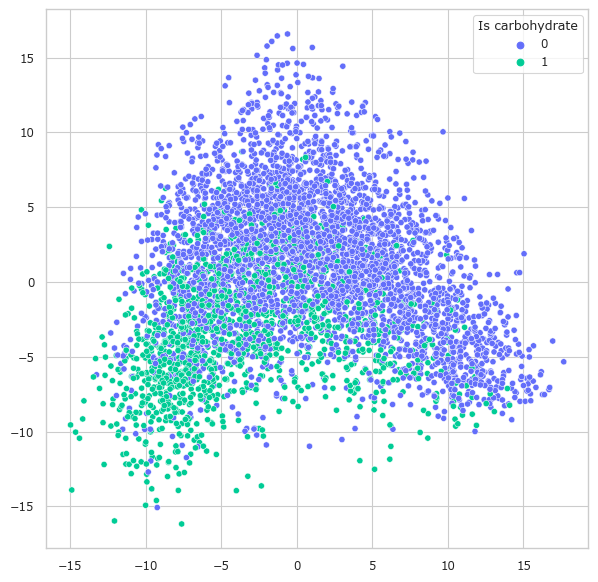

In [92]:
# df['Num. rings'].apply(lambda n: n / mol.GetNumAtoms())
init_plotting(figsize=(7, 7))
sns.scatterplot(x=pca_embs[:, 0], y=pca_embs[:, 1], s=20, hue=df['Is carbohydrate'])

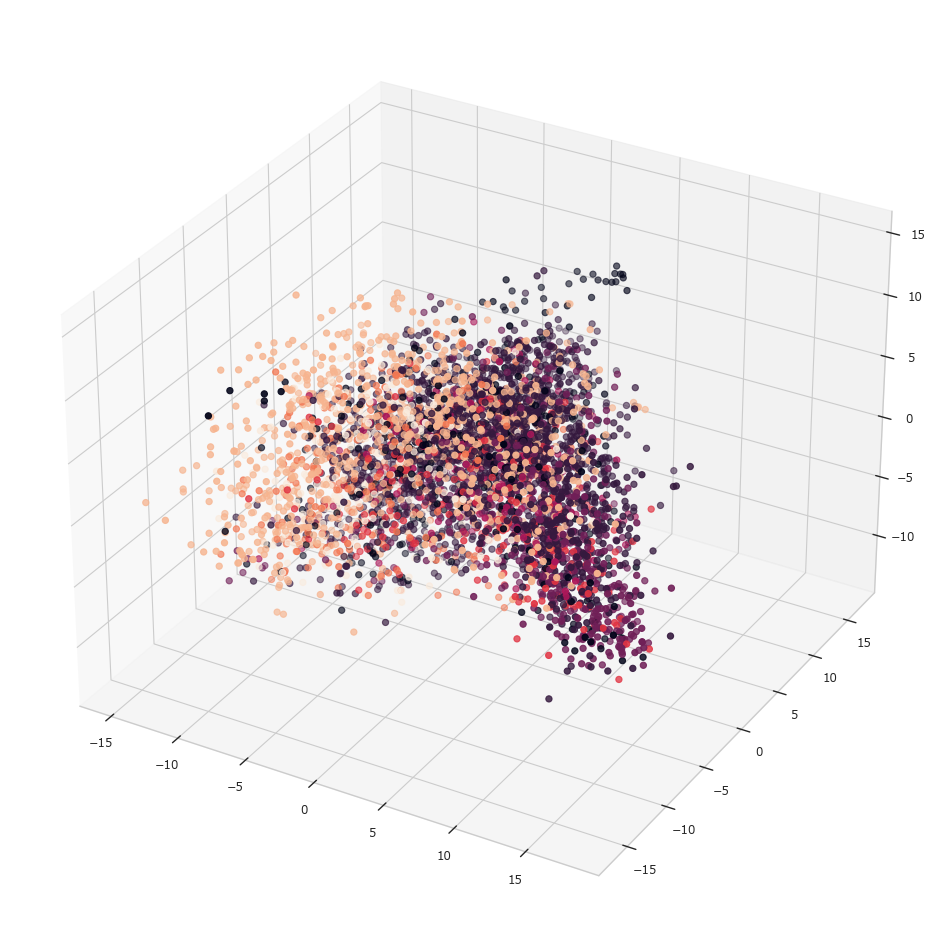

In [75]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(pca_embs[:, 0], pca_embs[:, 1], pca_embs[:, 2], c=df['pathway_results'].astype('category').cat.codes)
plt.show()

In [96]:
label_col = '#N'

if df[label_col].dtype == 'object':
    labels_ = df[label_col].astype('category').cat.rename_categories(range(df[label_col].nunique())).astype(int)
else:
    labels_ = df[label_col]

# generate a scatter plot
fig = px.scatter(x=pca_embs[:, 0], y=pca_embs[:, 1], color=labels_, width=700, height=600)#, color_discrete_sequence=px.colors.qualitative.Antique)`


# add molecules to the plotly graph - returns a Dash app
app = molplotly.add_molecules(fig=fig,
                              df=df,
                              smiles_col='SMILES',
                              title_col='NAME',
                              )

# run Dash app inline in notebook (or in an external server)
app.run_server(mode='inline', port=8700, height=600)

Dash is running on http://127.0.0.1:8700/



# .mzML

In [103]:
import dreams.utils.io as io
import dreams.utils.dformats as dformats
from dreams.definitions import *

In [107]:
df_mzml = io.read_mgf(DATA_DIR / 'tito' / 'feat_list_fbmn.mgf', smiles_col=None)
df_mzml = dformats.to_A_format(df_mzml, add_msn_col=False)  # TODO: check out without filtering
df_mzml

7267it [00:01, 6609.02it/s]


Initial size: 7267
1 <= charge <= 1: 7190
Precursor m/z <= 1000.0: 7190
Intensity amplitude >= 20.0: 6156
Num. high (>= 0.1) peaks >= 3: 4719


PARSED PEAKS feature_id  \
0     [[47.78714, 48.03713, 53.50368, 55.04774, 56.4...          1   
1     [[44.46429, 45.39898, 47.41814, 48.61242, 50.8...          2   
2     [[49.02125, 51.33707, 53.70722, 54.08154, 54.9...          3   
3     [[46.76186, 68.74821, 84.95452, 84.95938, 91.6...          4   
4     [[40.96998, 42.98465, 55.95704, 56.96116, 56.9...          5   
...                                                 ...        ...   
4714  [[55.01762, 55.054, 57.03325, 57.06962, 67.053...       7263   
4715  [[69.06999, 77.76265, 81.06975, 81.89662, 81.9...       7264   
4716  [[55.05413, 57.06966, 67.05402, 69.06959, 71.0...       7265   
4717  [[55.05433, 57.06968, 58.89534, 69.06969, 71.0...       7266   
4718  [[114.90337, 147.30988, 202.0777, 327.07889, 3...       7267   

                pepmass scans mslevel  \
0     (249.92568, None)     1       2   
1     (244.94676, None)     2       2   
2     (272.94176, None)     3       2   
3     (232.92823, None)     4       2   
4     (125.98623, None)     5       2   
...                 ...   ...     ...   
4714  (348.32616, None)  7263       2   
4715  (456.34726, None)  7264       2   
4716  (415.35719, None)  7265       2   
4717  (431.35203, None)  7266       2   
4718  (708.51106, None)  7267       2   

                                           merged_stats  retention_time  \
0     8 / 8 (0 removed due to low quality, 0 removed...          51.077   
1     5 / 5 (0 removed due to low quality, 0 removed...          51.154   
2     17 / 18 (1 removed due to low quality, 0 remov...          51.317   
3     1 / 1 (0 removed due to low quality, 0 removed...          51.729   
4     1 / 2 (1 removed due to low quality, 0 removed...          51.779   
...                                                 ...             ...   
4714  1 / 1 (0 removed due to low quality, 0 removed...        1035.914   
4715  1 / 1 (0 removed due to low quality, 0 removed...        1035.914   
4716  1 / 1 (0 removed due to low quality, 0 removed...        1036.165   
4717  1 / 1 (0 removed due to low quality, 0 removed...        1036.434   
4718  1 / 1 (0 removed due to low quality, 0 removed...        1037.201   

      CHARGE  PRECURSOR M/Z  
0          1      249.92568  
1          1      244.94676  
2          1      272.94176  
3          1      232.92823  
4          1      125.98623  
...      ...            ...  
4714       1      348.32616  
4715       1      456.34726  
4716       1      415.35719  
4717       1      431.35203  
4718       1      708.51106  

[4719 rows x 9 columns]

In [109]:
val_mzml = du.ManualValidation(df_mzml, DataFormatA())
embs_mzml = get_embeddings(model, val_mzml.get_data(), batch_size=8, tqdm_batches=True)
embs_mzml.shape

100%|██████████| 590/590 [02:23<00:00,  4.11it/s]


torch.Size([4719, 1024])

In [113]:
embs_all = torch.cat([embs, embs_mzml])

In [114]:
# generate a scatter plot
fig = px.scatter(x=embs_all[:, 0], y=embs_all[:, 1], color=['Ref'] * embs.shape[0] + ['Experiment'] * embs_mzml.shape[0], width=700, height=600)#, color_discrete_sequence=px.colors.qualitative.Antique)`
#
#
# # add molecules to the plotly graph - returns a Dash app
# app = molplotly.add_molecules(fig=fig,
#                               df=df,
#                               smiles_col='SMILES',
#                               title_col='NAME',
#                               )
#
# # run Dash app inline in notebook (or in an external server)
# app.run_server(mode='inline', port=8700, height=600)
fig.show()